## Reset Previous Work

In [1]:
pth = "/bigstore/GeneralStorage/fangming/projects/test_merfish/data"

In [2]:
from MERFISH_Objects.execute_class import *
import shutil

2022-08-24 12:18:32,497 [INFO] WRITING LOG OUTPUT TO /home/fangming/.cellpose/run.log


In [3]:
import importlib
# importlib.reload(MERFISH_Objects.execute_class)

In [4]:
cword_config = 'merfish_config_zebrafinch'
config = importlib.import_module(cword_config)

In [5]:
metadata_path = '/bigstore/Images2022/Gaby/Zebrafinch/Zebra_B0_2022Jul11/'
dataset = [i for i in metadata_path.split('/') if not i==''][-1]
cword_config = 'merfish_config_zebrafinch'
config = importlib.import_module(cword_config)
parameters = config.parameters
fishdata_path = os.path.join(metadata_path, parameters['fishdata'])
utilities_path = parameters['utilities_path']

In [6]:
for key in parameters:
    if key.endswith('path') or key.endswith('data'):
        print(key, parameters[key])
print(fishdata_path)

daemon_path /scratch/test_daemon_FX
utilities_path /scratch/test_merfish_FX
fishdata fishdata_testFX
/bigstore/Images2022/Gaby/Zebrafinch/Zebra_B0_2022Jul11/fishdata_testFX


In [7]:
import time
from tqdm import trange
import pandas as pd
from collections import Counter
import numpy as np
from Bio import SeqIO

In [8]:
from MERFISH_Objects.execute_class import *
metadata_path = '/bigstore/Images2022/Gaby/Zebrafinch/Zebra_B0_2022Jul11/'
dataset = [i for i in metadata_path.split('/') if not i==''][-1]
cword_config = 'merfish_config_zebrafinch'
config = importlib.import_module(cword_config)
bitmap = config.bitmap
parameters = config.parameters

In [9]:
posname = '7-Pos004_003'#image_metadata.posnames[0]

# Process Single Position

### Spot Calling

In [10]:
Input = []
hybe = 'hybe2'
channel = 'FarRed'
self = Stack_Class(metadata_path,dataset,posname,hybe,channel,cword_config,verbose=False)
self.check_projection()
zindexes = self.zindexes

x_window = [500,750]
y_window = [1000,1250]

In [11]:
%%time
zindex = str(zindexes[0])
# stks = {}

# raw_dapis = {}

rawimgs = {}
imgs = {}
spots_coords = {}
spots_coords_v2 = {}

for i, (readout,hybe,channel) in enumerate(bitmap):
    print(readout,hybe,channel)
    """ Processed Image Zoom"""
    # self = Image_Class(metadata_path,dataset,posname,hybe,'DeepBlue',zindex,cword_config,verbose=False)
    # self.load_data() # sub_stk
    # self.project() # max projection
    # raw_dapis[i] = self.img # are these correct?
    
    self = Image_Class(metadata_path,dataset,posname,hybe,channel,zindex,cword_config,verbose=False)
    self.load_data() # sub_stk
    # stks[i] = self.sub_stk
    self.project() # max projection
    rawimgs[i] = self.img
    
    fish_img = self.fishdata.load_data('image',
                                        dataset=self.dataset,
                                        posname=self.posname,
                                        hybe=self.hybe,
                                        channel=self.channel,
                                        zindex=self.zindex)/self.parameters['gain']
    imgs[i] = fish_img
    self.img = fish_img # trying this and see; this is important
    
    self.parameters['spot_max_distance'] = 3#self.parameters['spot_parameters']['default']['spot_max_distance']
    self.parameters['spot_minmass'] = 5#self.parameters['spot_parameters']['default']['spot_minmass']
    self.parameters['spot_diameter'] = 5#self.parameters['spot_parameters']['default']['spot_diameter']
    self.parameters['spot_separation'] = 3#self.parameters['spot_parameters']['default']['spot_separation']
    self.call_spots()
    spots_coords[i] = np.vstack([self.spots.x, self.spots.y]).T

    self.parameters['spot_max_distance'] = 3#self.parameters['spot_parameters']['default']['spot_max_distance']
    self.parameters['spot_minmass'] = 10#self.parameters['spot_parameters']['default']['spot_minmass']
    self.parameters['spot_diameter'] = 5#self.parameters['spot_parameters']['default']['spot_diameter']
    self.parameters['spot_separation'] = 3#self.parameters['spot_parameters']['default']['spot_separation']
    self.call_spots()
    spots_coords_v2[i] = np.vstack([self.spots.x, self.spots.y]).T

RS0095 hybe1 FarRed
RS0109 hybe2 FarRed
RS0175 hybe3 FarRed
RS0237 hybe4 FarRed
RS0307 hybe5 FarRed
RS0332 hybe6 FarRed
RS0384 hybe10 FarRed
RS0406 hybe11 FarRed
RS0451 hybe12 FarRed
RS0468 hybe13 FarRed
RS0548 hybe14 FarRed
RS64.0 hybe15 FarRed
RS156.0 hybe19 FarRed
RS278.0 hybe20 FarRed
RS313.0 hybe21 FarRed
RS643.0 hybe22 FarRed
RS740.0 hybe23 FarRed
RS810.0 hybe24 FarRed
CPU times: user 51.3 s, sys: 56.7 s, total: 1min 47s
Wall time: 2min 44s


In [12]:

# fig, axs = plt.subplots(3,6,figsize=(4*6,4*3), sharex=True, sharey=True)
# for i, ax in zip(raw_dapis.keys(), axs.flat):
#     img = raw_dapis[i]
#     vmin = np.percentile(img.reshape(-1,), 50)
#     vmax = np.percentile(img.reshape(-1,), 95)
#     g = ax.imshow(img, cmap='jet', vmin=vmin, vmax=vmax)
#     ax.set_aspect('equal')
#     ax.set_title(f'bit{i}')
#     fig.colorbar(g, ax=ax, shrink=0.5, location='bottom', pad=0.05, fraction=0.05, ticks=[vmin, vmax])
# fig.subplots_adjust(wspace=0)
# fig.suptitle(f"Raw images (Max projected) {posname}", y=0.92)
# plt.show()

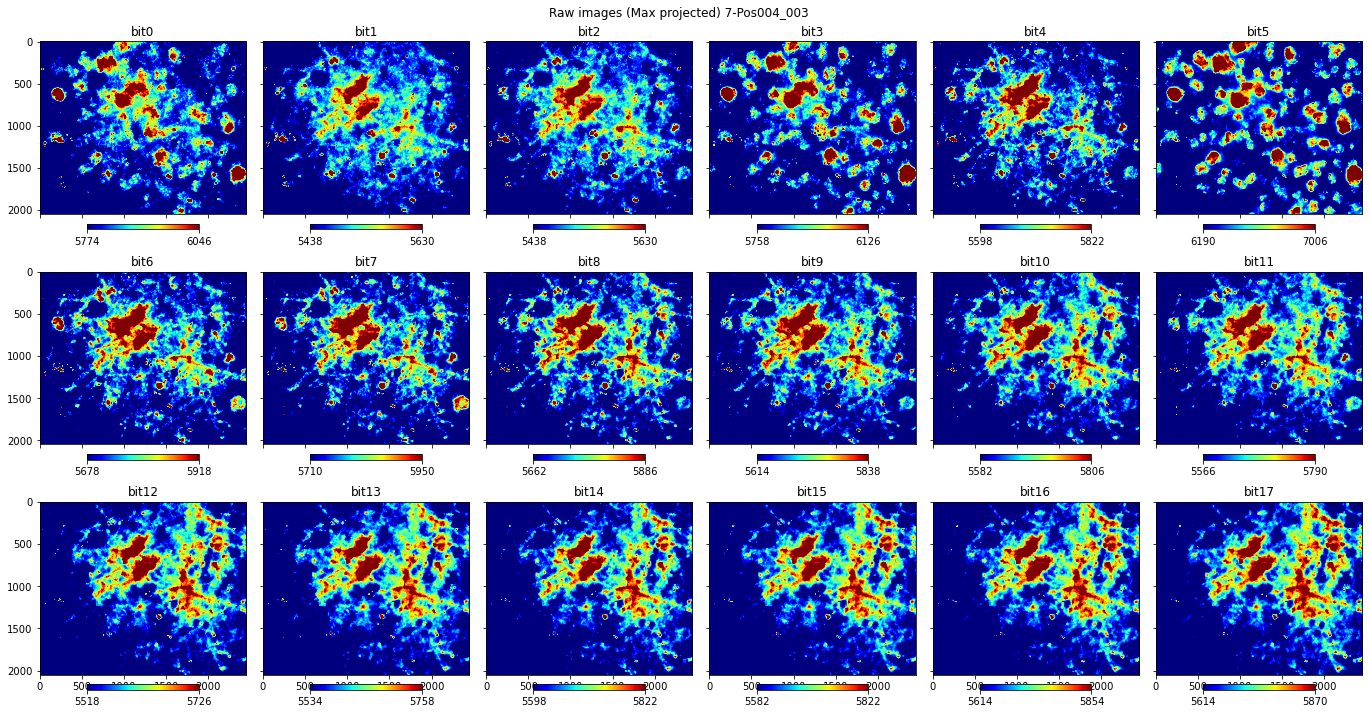

In [13]:
fig, axs = plt.subplots(3,6,figsize=(4*6,4*3), sharex=True, sharey=True)
for i, ax in zip(rawimgs.keys(), axs.flat):
    img = rawimgs[i]
    vmin = np.percentile(img.reshape(-1,), 50)
    vmax = np.percentile(img.reshape(-1,), 95)
    g = ax.imshow(img, cmap='jet', vmin=vmin, vmax=vmax)
    ax.set_aspect('equal')
    ax.set_title(f'bit{i}')
    fig.colorbar(g, ax=ax, shrink=0.5, location='bottom', pad=0.05, fraction=0.05, ticks=[vmin, vmax])
fig.subplots_adjust(wspace=0)
fig.suptitle(f"Raw images (Max projected) {posname}", y=0.92)
plt.show()

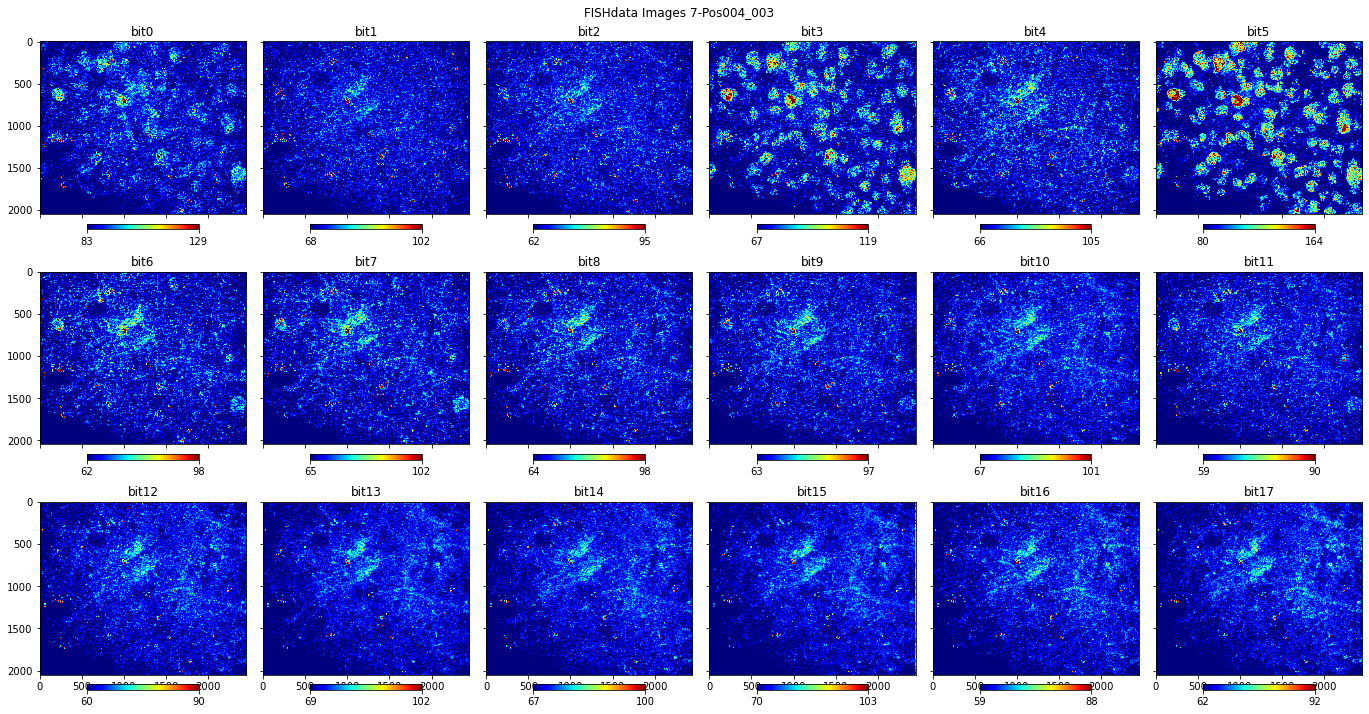

In [14]:
fig, axs = plt.subplots(3,6,figsize=(4*6,4*3), sharex=True, sharey=True)
for i, ax in zip(imgs.keys(), axs.flat):
    img = imgs[i]
    vmin = np.percentile(img.reshape(-1,), 50)
    vmax = np.percentile(img.reshape(-1,), 95)
    g = ax.imshow(img, cmap='jet', vmin=vmin, vmax=vmax)
    ax.set_aspect('equal')
    ax.set_title(f'bit{i}')
    fig.colorbar(g, ax=ax, shrink=0.5, location='bottom', pad=0.05, fraction=0.05, ticks=[vmin, vmax])
fig.subplots_adjust(wspace=0)
fig.suptitle(f"FISHdata Images {posname}", y=0.92)
plt.show()

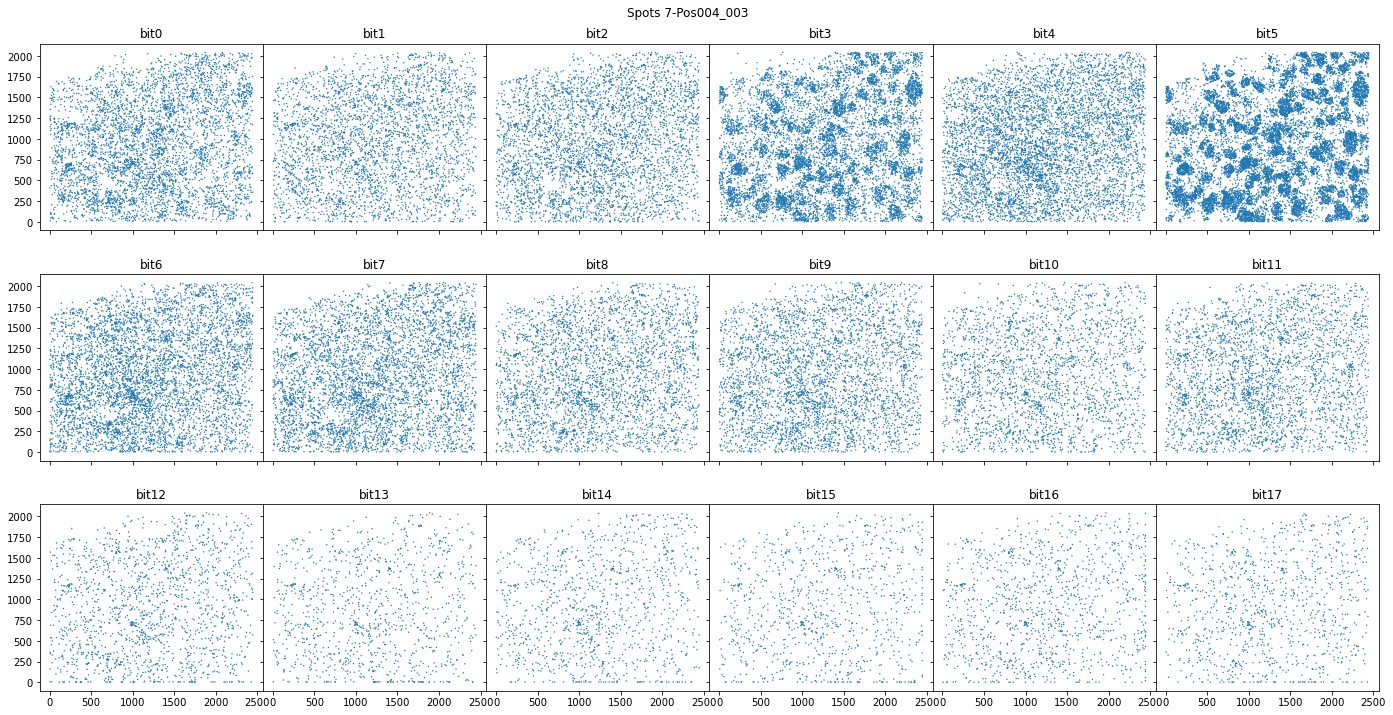

In [15]:
fig, axs = plt.subplots(3,6,figsize=(4*6,4*3), sharex=True, sharey=True)
for i, ax in zip(spots_coords.keys(), axs.flat):
    spots = spots_coords[i]
    ax.scatter(spots[:,0], spots[:,1], s=2, edgecolor='none')
    ax.set_aspect('equal')
    ax.set_title(f'bit{i}')
fig.subplots_adjust(wspace=0)
fig.suptitle(f"Spots {posname}", y=0.92)
plt.show()

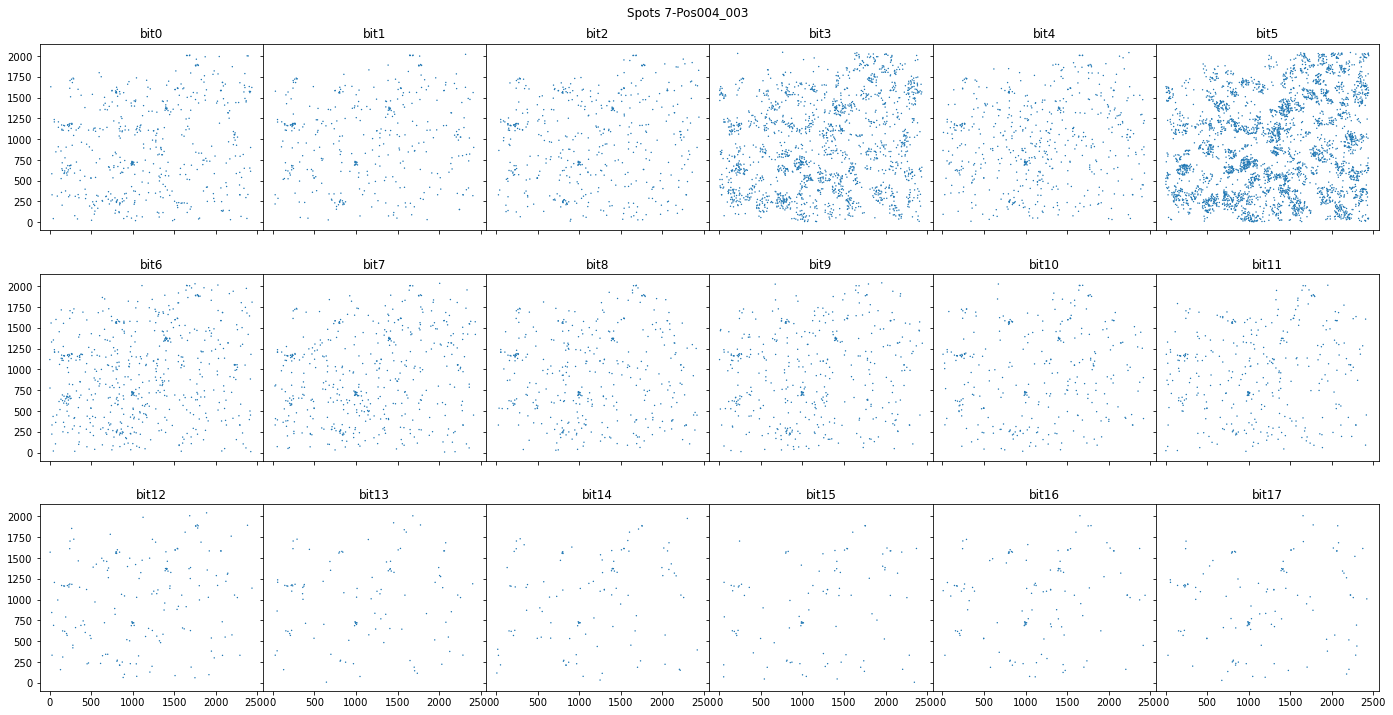

In [16]:
fig, axs = plt.subplots(3,6,figsize=(4*6,4*3), sharex=True, sharey=True)
for i, ax in zip(spots_coords.keys(), axs.flat):
    spots = spots_coords_v2[i]
    ax.scatter(spots[:,0], spots[:,1], s=2, edgecolor='none')
    ax.set_aspect('equal')
    ax.set_title(f'bit{i}')
fig.subplots_adjust(wspace=0)
fig.suptitle(f"Spots {posname}", y=0.92)
plt.show()

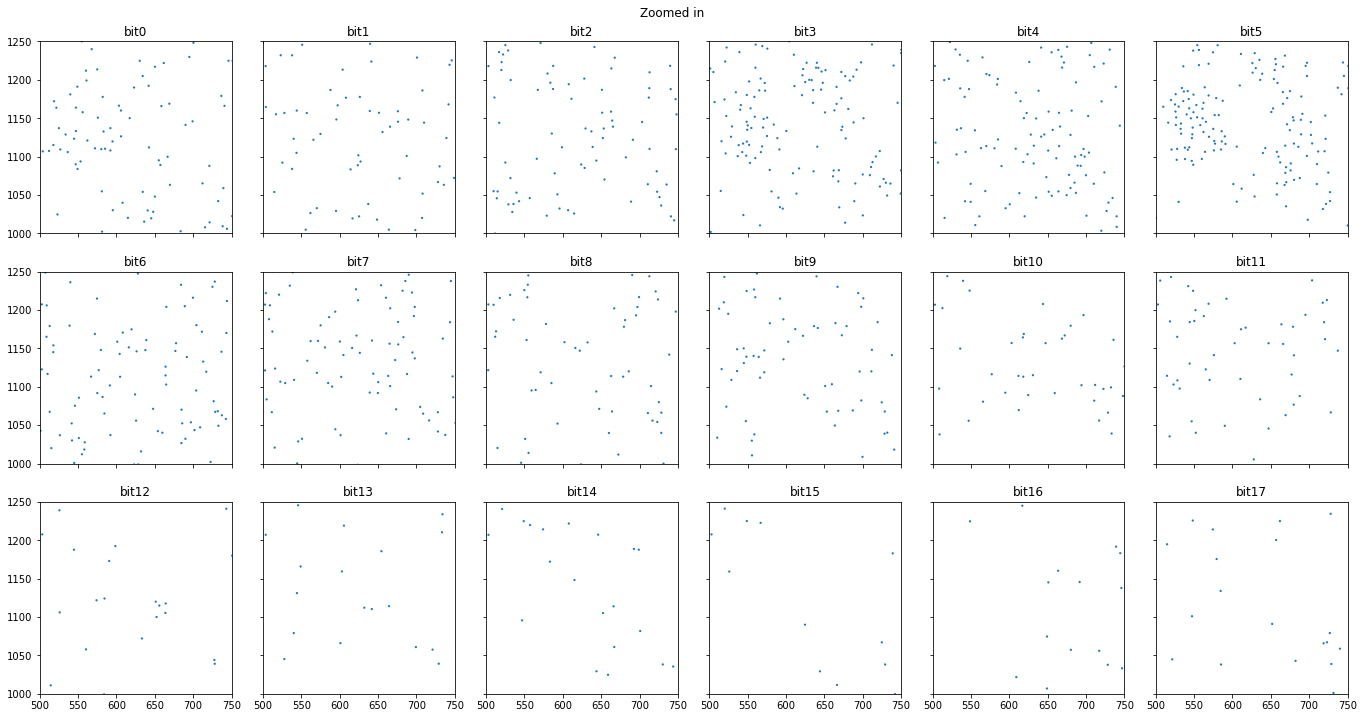

In [17]:
fig, axs = plt.subplots(3,6,figsize=(4*6,4*3), sharex=True, sharey=True)
for i, ax in zip(spots_coords.keys(), axs.flat):
    spots = spots_coords[i]
    ax.scatter(spots[:,0], spots[:,1], s=5, edgecolor='none')
    ax.set_aspect('equal')
    ax.set_title(f'bit{i}')
    ax.set_xlim(x_window)
    ax.set_ylim(y_window)
fig.subplots_adjust(wspace=0)
fig.suptitle("Zoomed in", y=0.92)
plt.show()

# Here is a good place to explore spots pairings
- counting the overlap beteween rounds of images and spots

In [18]:

spots_a = spots_coords[0]
spots_b = spots_coords[1]

In [19]:
spots_a

array([[1943.14102564,    2.30769231],
       [  79.944     ,    3.08      ],
       [ 248.33742331,    4.63803681],
       ...,
       [2278.73863636, 2033.08522727],
       [2080.04663212, 2040.22797927],
       [1873.66666667, 2041.33333333]])

In [20]:
from scipy.spatial import cKDTree

In [ ]:
index = cKDTree.index(spots_a)

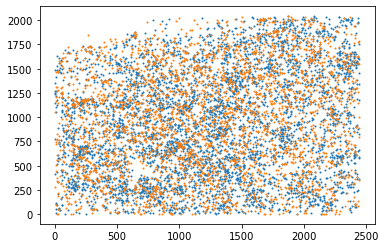

In [22]:
plt.scatter(spots_a[:,0], spots_a[:,1], s=1)
plt.scatter(spots_b[:,0], spots_b[:,1], s=1)